In [509]:
import os as os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy as sp
%matplotlib inline
## set path
if os.name =="nt":
    path="J:\\Project\\Cost_effectiveness\\dev\\"
else:
    path ="\home\\j\\Project\\Cost_effectiveness\\dev\\"
    
allelse ="data_processed"
ltable = "data\\gbd"



### Read in data

In [510]:
#life table
os.chdir(path+ltable)
ltable= np.array(pd.read_csv("interpolated_reference_life_table.csv"))

os.chdir(path+allelse)

## read in pop
cohort = pd.read_csv("Hello_World_Population.csv")
cohort = np.array(cohort.filter(['age','sex']))

## read in mort
mort  =pd.read_csv("Mortality_rates.csv")
## convert ages to age at 1990
mort_inv =mort.copy()
mort_inv['Year'] -= 1990
mort_inv['Age'] -= mort_inv['Year']
mort_inv = mort_inv[mort_inv['Age']>0]
mort_inv.head()
## convert to wide
mort_inv = mort_inv.pivot_table('Mortality_Rate', ['Age', 'sex'], 'Year').reset_index()
mort_inv= mort_inv[mort_inv['Age']<=80]
mort_inv.ix[:,2:] =1-mort_inv.ix[:,2:]
mort_inv = np.array(mort_inv)

### Setup cumulative density mortality

In [511]:
# easier way???

### no tx cumulative
mort_notx=np.empty([len(mort_inv), len(mort_inv[1])])
mort_notx[:,0:3]= mort_inv[:,0:3]
for i in xrange(3,len(mort_notx[1])):
    mort_notx[:,i] = mort_notx[:,i-1] *mort_inv[:,i]

    
#tx cumlative denisity
mort_tx=np.empty([len(mort_inv), len(mort_inv[1])])
mort_tx[:,0:3]= mort_inv[:,0:3]
for i in xrange(3,len(mort_tx[1])):
    ##1995 no tx
    if (i)<7:
        mort_tx[:,i] = mort_tx[:,i-1] *mort_inv[:,i]
    else:
        #have to be >=25 to start tx after 1995
        j= 48-(i-3)*2 
        mort_tx[0:j,i] = mort_tx[0:j,i-1] *mort_inv[0:j,i]
        # messy oops
        #tx halfs mortality
        mort_tx[j:,i] = mort_tx[j:,i-1] *(1- (1-mort_inv[j:,i])/2)


### Check cumulative denisty

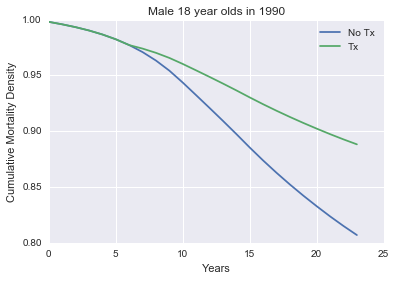

In [525]:
sns.set_style("darkgrid")
plt.plot(mort_notx[36,2:], label='No Tx')
plt.plot(mort_tx[36,2:], label ='Tx')
plt.xlabel('Years')
plt.ylabel('Cumulative Mortality Density')
plt.title('Male 18 year olds in 1990')
plt.legend()
plt.show()

In [513]:
class MWM(object):
    
    """TODO:
    (1) make more flexible... my brain isn't that
    creative right now
    
    (2) not sure how this will scale to more complex model...
    need to put some thought into it
    
    (3) setup interpolater... issues with the spline estimating out of range
    """
    def __init__(self, n=1e4, time=24):
        np.random.seed(1)
        self.n =int(n)
        self.time= int(time)
        
        # set attributes
        self.attributes = pd.DataFrame(index= np.arange(self.n),
                        columns=['age1990', 'sex', 'death_notx', 'death_tx'])
        
        ## bring in pop
        self.attributes.ix[:,0:2] = cohort[np.random.choice(10000,self.n, replace =False)]
        
        ## setup interpolate between points
        ## TODO: try to set this an interpolater..
#         self.notx_dict = {}
#         self.tx_dict = {}
        
#         for i in np.arange(len(mort_tx)):
#             self.notx_dict[i] = sp.interpolate.UnivariateSpline(mort_notx[i,2:], np.arange(self.time) )
#             self.notx_dict[i] = sp.interpolate.UnivariateSpline(mort_tx[i,2:], np.arange(self.time) )
 
    def terminator(self):
        rand= np.random.uniform(0,1, self.n).reshape([self.n,1])
        
        ## When do you age? when do 
        self.attributes['death_tx'] = self.attributes['age1990'] + np.sum(mort_tx[self.attributes['age1990']*
                            2-3+ self.attributes['sex'],2:]>=rand, axis=1)
        self.attributes['death_notx'] = self.attributes['age1990'] + np.sum(mort_notx[self.attributes['age1990']*
                            2-3+ self.attributes['sex'],2:]>=rand, axis=1)
                                                                               
    def yolloer(self):
        ## maybe there is a simpler way???
        death = ['death_notx', 'death_tx']
        yll = ['yll_death_notx', 'yll_death_tx']
                       
        for i in np.arange(2):
            ## really life expectancy at age of death
            self.attributes[yll[i]] = ltable[(self.attributes[death[i]]).astype('int'),1]
            
            ## cap yll
            self.attributes[yll[i]] =np.where((self.attributes[death[i]]-self.attributes['age1990'])>=self.time,
                                              0, self.attributes[yll[i]])
            delta = self.attributes[death[i]] - self.attributes['age1990']
            self.attributes[yll[i]] = np.where((delta+self.attributes[yll[i]])>self.time, 
                                               self.time-delta, self.attributes[yll[i]])
    
    def cost_add(self):
        ## apply statements are slow... this method may not work with scale as it creates a big matrix.
        df = self.attributes# got tired of writing self.attributes
        #add calc age for everyone in every year
        tx_year =np.array(df['age1990']).reshape([len(df),1]) + np.array([np.arange(24)]*len(df)).reshape([len(df), 24])
        ## tx start 1995
        tx_year[:,0:5] =0 
        # tx for >=25
        tx_year = np.where(tx_year>=25, tx_year, 0)
        #no tx while dead
        tx_year = np.where(tx_year >np.array(df['death_tx']).reshape([len(df),1]), 0, tx_year)
        #count years with tx
        self.attributes['total_cost'] =np.sum(tx_year>0, axis=1)*2 ## add cost
        
    def summary(self):
        self.yll_adverted = self.attributes['yll_death_notx'].sum() -self.attributes['yll_death_tx'].sum()
        self.total_cost = self.attributes['total_cost'].sum()
        


In [518]:
m= MWM()

## run model
%timeit m.terminator()

## post estimation
m.yolloer()

m.cost_add()

m.summary()

print m.total_cost
print m.yll_adverted
print m.total_cost/m.yll_adverted
##ignore warnings... I know what I am doing :) 

C:\Users\mwm6\AppData\Local\Continuum\Miniconda2\lib\site-packages\ipykernel\__main__.py:38: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future
C:\Users\mwm6\AppData\Local\Continuum\Miniconda2\lib\site-packages\ipykernel\__main__.py:40: DeprecationWarning: non integer (and non boolean) array-likes will not be accepted as indices in the future


100 loops, best of 3: 10.8 ms per loop
202662
5347.75931258
37.8966195287


In [517]:
m.attributes.head(50)

,age1990,sex,death_notx,death_tx,yll_death_notx,yll_death_tx,total_cost
0,75,2,75,75,9.43737,9.43737,0
1,10,1,34,34,0,0,18
2,15,1,39,39,0,0,28
3,10,1,34,34,0,0,18
4,15,1,30,34,9,5,20
5,35,1,59,59,0,0,38
6,5,2,29,29,0,0,8
7,5,1,29,29,0,0,8
8,5,2,29,29,0,0,8
9,80,2,84,84,5.58806,5.58806,0
